In [2]:
import os
import glob
import pandas as pd
import numpy as np
import json 

base_folder = r'C:\Users\mamuj\Downloads\22F-3650_SE-6A_A2_DataScience\raw'
weather_data_folder = os.path.join(base_folder, 'weather_raw_data')
electricity_data_folder = os.path.join(base_folder, 'electricity_raw_data')

print(f"Current working directory: {os.getcwd()}")

# Function to load data from a folder
def load_data(folder_path, file_extension):
    all_files = glob.glob(os.path.join(folder_path, f'*.{file_extension}'))
    dataframes = []

    for file in all_files:
        try:
            if file_extension == 'csv':
                df = pd.read_csv(file, parse_dates=['date'])
                df['date'] = df['date'].dt.tz_localize(None)  # Remove timezone if present
                dataframes.append(df)
                
            elif file_extension == 'json':
                with open(file, 'r') as f:
                    data = json.load(f)
                    
                # Normalize JSON into a DataFrame
                json_df = pd.json_normalize(data['response']['data'])
                
                # Convert "period" column to datetime
                json_df['date'] = pd.to_datetime(json_df['period'], format='%Y-%m-%dT%H')
                json_df.drop(columns=['period'], inplace=True)  # Drop the original period column
                
                # Convert 'value' column to numeric type
                json_df['value'] = pd.to_numeric(json_df['value'], errors='coerce')

                dataframes.append(json_df)

            else:
                print(f"Unsupported file extension: {file_extension}")

        except Exception as e:
            print(f"Error loading {file}: {e}")

    if not dataframes:
        print(f"No files found in {folder_path} with extension .{file_extension}")
        return pd.DataFrame()  # Return an empty dataframe if no files were loaded

    return pd.concat(dataframes, ignore_index=True)

# Load weather data (assuming CSV files)
weather_df = load_data(weather_data_folder, 'csv')
print(f"Weather Data: {weather_df.shape}")

# Load electricity demand data (assuming JSON files)
electricity_df = load_data(electricity_data_folder, 'json')
print(f"Electricity Demand Data: {electricity_df.shape}")

# Check if dataframes are empty
if weather_df.empty or electricity_df.empty:
    print("One or both dataframes are empty. Cannot proceed with merging.")
else:
    # Ensure both DataFrames have the same date format
    weather_df['date'] = weather_df['date'].dt.floor('H')  # Round to the nearest hour
    electricity_df['date'] = electricity_df['date'].dt.floor('H')

    merged_df = pd.merge(weather_df, electricity_df, on='date', how='inner')
    print(f"Merged Data: {merged_df.shape}")

    # Log the number of records and features
    print(f"Number of records: {merged_df.shape[0]}")
    print(f"Number of features: {merged_df.shape[1]}")

    print(merged_df.info())
    print(merged_df.describe())

Current working directory: C:\Users\mamuj
Weather Data: (127584, 2)
Electricity Demand Data: (301642, 7)
Merged Data: (1435764, 8)
Number of records: 1435764
Number of features: 8
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1435764 entries, 0 to 1435763
Data columns (total 8 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   date            1435764 non-null  datetime64[ns]
 1   temperature_2m  1435764 non-null  float64       
 2   subba           1435764 non-null  object        
 3   subba-name      1435764 non-null  object        
 4   parent          1435764 non-null  object        
 5   parent-name     1435764 non-null  object        
 6   value           1435764 non-null  int64         
 7   value-units     1435764 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 87.6+ MB
None
                                date  temperature_2m         value
count         

In [3]:
missing_values = merged_df.isnull().sum()
missing_percentage = (missing_values / len(merged_df)) * 100
print(pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage}))

                Missing Values  Percentage
date                         0         0.0
temperature_2m               0         0.0
subba                        0         0.0
subba-name                   0         0.0
parent                       0         0.0
parent-name                  0         0.0
value                        0         0.0
value-units                  0         0.0


In [4]:
print(f"Duplicate rows: {merged_df.duplicated().sum()}")
merged_df = merged_df.drop_duplicates()

Duplicate rows: 1146233


In [5]:
print(f"New dataset shape after removing duplicates: {merged_df.shape}")

New dataset shape after removing duplicates: (289531, 8)


In [6]:
print(f"Partial duplicates (same date & subba): {merged_df.duplicated(subset=['date', 'subba']).sum()}")

Partial duplicates (same date & subba): 0


In [7]:
merged_df['date'] = pd.to_datetime(merged_df['date'])
merged_df['hour'] = merged_df['date'].dt.hour
merged_df['day'] = merged_df['date'].dt.day
merged_df['month'] = merged_df['date'].dt.month
merged_df['year'] = merged_df['date'].dt.year
merged_df['day_of_week'] = merged_df['date'].dt.dayofweek
merged_df['is_weekend'] = merged_df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
# data type conversions

In [8]:
categorical_cols = ['subba', 'subba-name', 'parent', 'parent-name', 'value-units']
merged_df[categorical_cols] = merged_df[categorical_cols].astype('category')
# conveet categorical colums  to category type

In [9]:
Q1 = merged_df['value'].quantile(0.25)
Q3 = merged_df['value'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = merged_df[(merged_df['value'] < lower_bound) | (merged_df['value'] > upper_bound)]
print(f"Outliers detected: {len(outliers)}")

Outliers detected: 28496


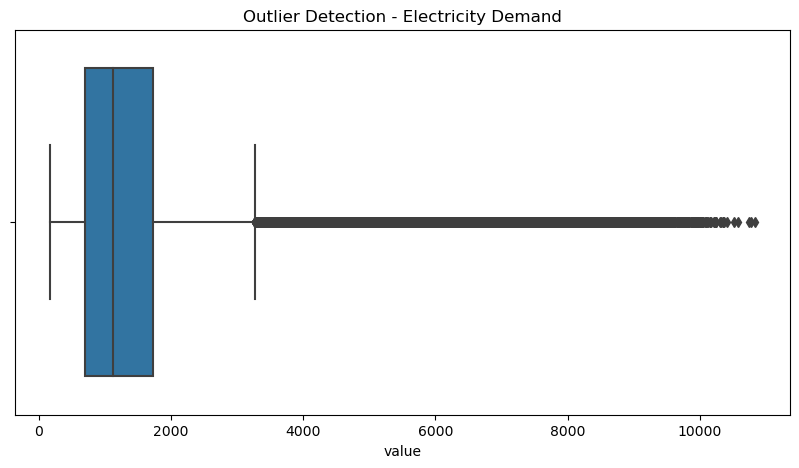

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.boxplot(x=merged_df["value"])
plt.title("Outlier Detection - Electricity Demand")
plt.show()

In [11]:
merged_df["value"] = np.where(merged_df["value"] > upper_bound, upper_bound, merged_df["value"])
merged_df["value"] = np.where(merged_df["value"] < lower_bound, lower_bound, merged_df["value"])

In [12]:
merged_df["day_of_week"] = merged_df["date"].dt.dayofweek
merged_df["is_weekend"] = merged_df["day_of_week"].apply(lambda x: 1 if x >= 5 else 0)
merged_df["hour"] = merged_df["date"].dt.hour
merged_df["month"] = merged_df["date"].dt.month

In [13]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
merged_df["temperature_scaled"] = scaler.fit_transform(merged_df[["temperature_2m"]])
merged_df["value_scaled"] = scaler.fit_transform(merged_df[["value"]])

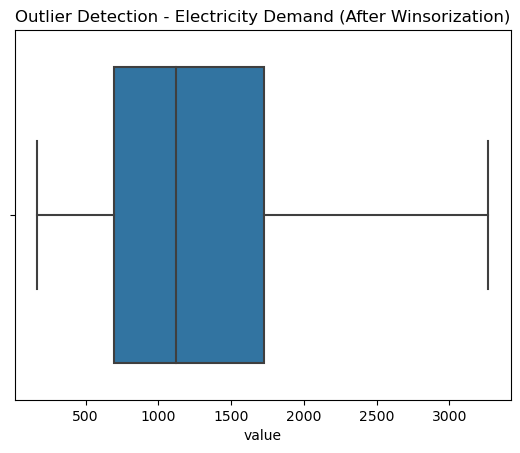

In [14]:
sns.boxplot(x=merged_df["value"])
plt.title("Outlier Detection - Electricity Demand (After Winsorization)")
plt.show()

In [15]:
# Display final dataset info
print(merged_df.info())
print(merged_df.head())

<class 'pandas.core.frame.DataFrame'>
Index: 289531 entries, 0 to 1435697
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date                289531 non-null  datetime64[ns]
 1   temperature_2m      289531 non-null  float64       
 2   subba               289531 non-null  category      
 3   subba-name          289531 non-null  category      
 4   parent              289531 non-null  category      
 5   parent-name         289531 non-null  category      
 6   value               289531 non-null  float64       
 7   value-units         289531 non-null  category      
 8   hour                289531 non-null  int32         
 9   day                 289531 non-null  int32         
 10  month               289531 non-null  int32         
 11  year                289531 non-null  int32         
 12  day_of_week         289531 non-null  int32         
 13  is_weekend          289531 non-nu

In [16]:
merged_df.to_csv("final_cleaned_data.csv", index=False)
print("Data saved to final_cleaned_data.csv")

Data saved to final_cleaned_data.csv


In [17]:
import os
print(os.getcwd())  # Check where it was saved

C:\Users\mamuj


In [18]:
# EDA
import pandas as pd

# Compute summary statistics
stats_summary = merged_df.describe()

# Compute skewness and kurtosis for numerical columns
skewness = merged_df[['temperature_2m', 'value']].skew()
kurtosis = merged_df[['temperature_2m', 'value']].kurtosis()

print("Statistical Summary:")
print(stats_summary)
print("\nSkewness:\n", skewness)
print("\nKurtosis:\n", kurtosis)

Statistical Summary:
                                date  temperature_2m          value  \
count                         289531   289531.000000  289531.000000   
mean   2023-07-03 13:28:18.309335040       11.346059    1339.497449   
min              2022-01-01 05:00:00      -10.491500     168.000000   
25%              2022-10-02 09:00:00        5.008500     696.000000   
50%              2023-07-03 13:00:00       10.808500    1120.000000   
75%              2024-04-02 18:00:00       17.408500    1725.000000   
max              2025-01-02 00:00:00       37.708500    3268.500000   
std                              NaN        8.095719     838.820744   

                hour            day          month           year  \
count  289531.000000  289531.000000  289531.000000  289531.000000   
mean       11.502223      15.721857       6.517648    2023.002887   
min         0.000000       1.000000       1.000000    2022.000000   
25%         6.000000       8.000000       4.000000    2022.0000

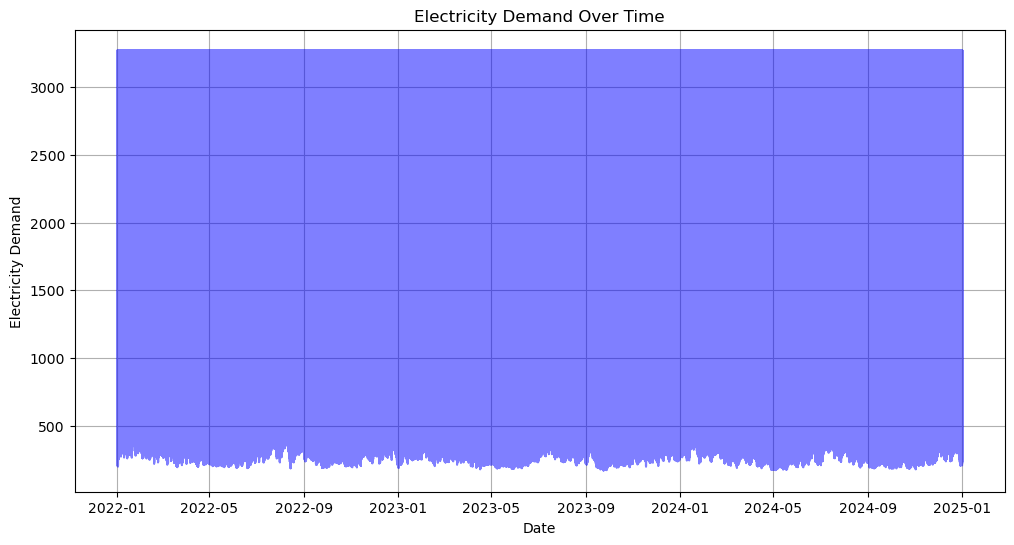

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(merged_df['date'], merged_df['value'], color='blue', alpha=0.5)
plt.xlabel("Date")
plt.ylabel("Electricity Demand")
plt.title("Electricity Demand Over Time")
plt.grid(True)
plt.show()

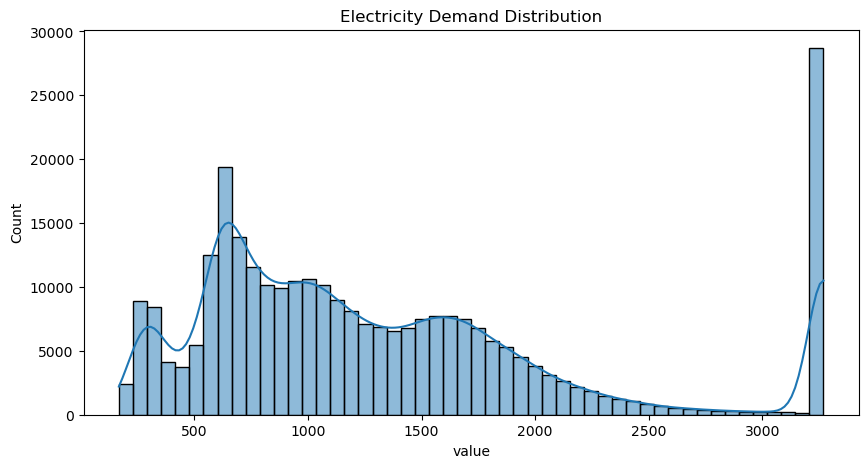

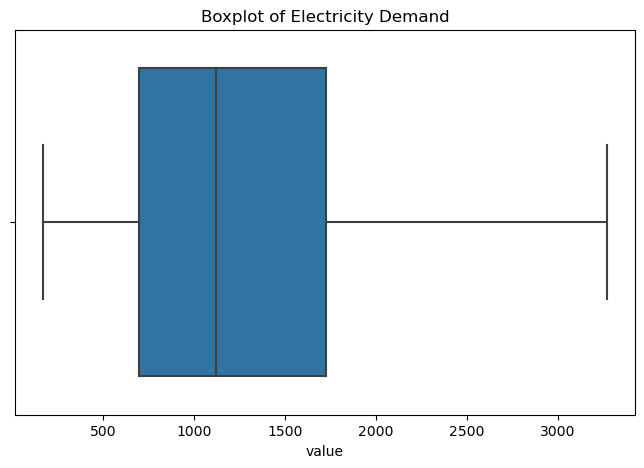

In [20]:
import seaborn as sns

# Histogram
plt.figure(figsize=(10, 5))
sns.histplot(merged_df['value'], bins=50, kde=True)
plt.title("Electricity Demand Distribution")
plt.show()

# Boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(x=merged_df['value'])
plt.title("Boxplot of Electricity Demand")
plt.show()

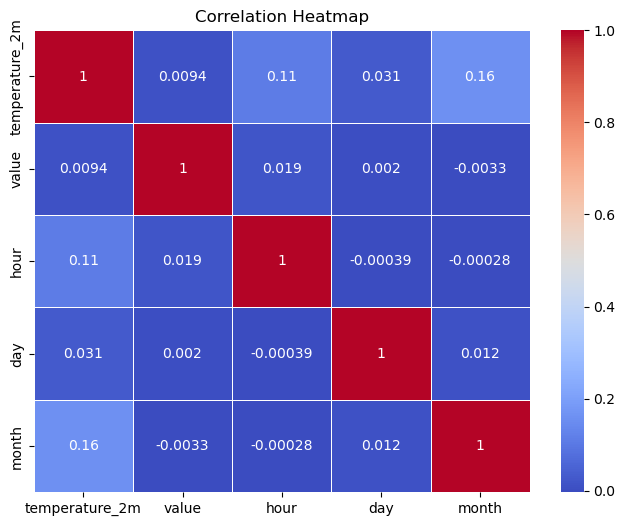

In [21]:
import seaborn as sns
import numpy as np

corr_matrix = merged_df[['temperature_2m', 'value', 'hour', 'day', 'month']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

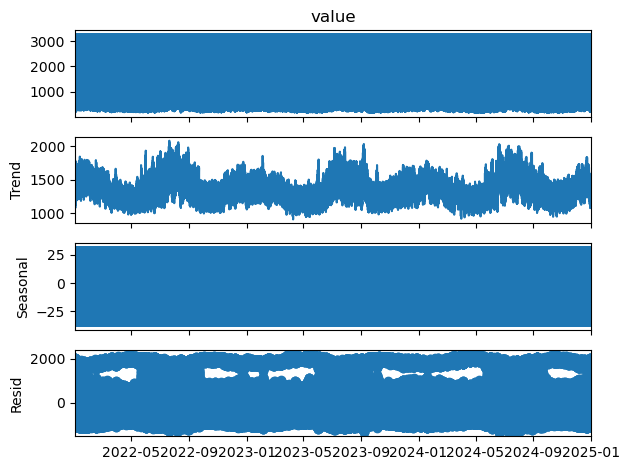

In [22]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(merged_df.set_index('date')['value'], model='additive', period=24)
decomposition.plot()
plt.show()

In [23]:
from statsmodels.tsa.stattools import adfuller

sampled_values = merged_df['value']

adf_test = adfuller(sampled_values)
print(f"ADF Statistic: {adf_test[0]}")
print(f"P-value: {adf_test[1]}")


ADF Statistic: -23.98455144127371
P-value: 0.0


Outliers detected using Z-score method: 0


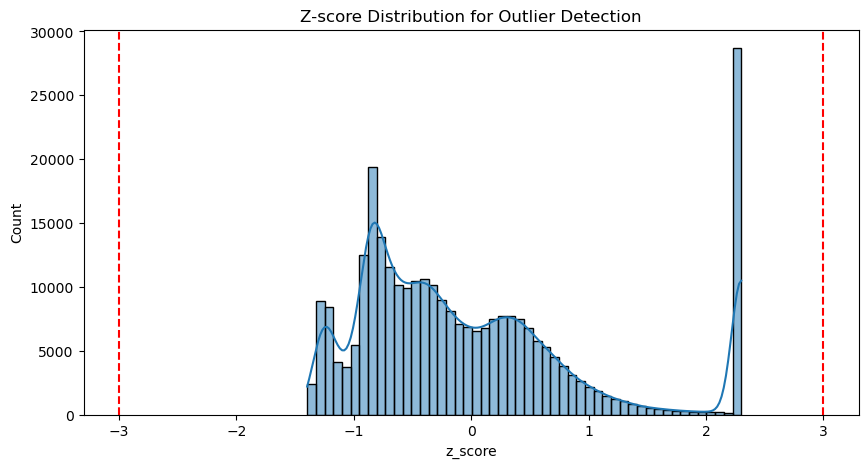

In [24]:
from scipy.stats import zscore

# Compute Z-scores
merged_df['z_score'] = zscore(merged_df['value'])

# Identify outliers (|Z| > 3)
z_outliers = merged_df[abs(merged_df['z_score']) > 3]
print(f"Outliers detected using Z-score method: {len(z_outliers)}")

# Visualize distribution
plt.figure(figsize=(10, 5))
sns.histplot(merged_df['z_score'], bins=50, kde=True)
plt.axvline(x=-3, color='red', linestyle='dashed')
plt.axvline(x=3, color='red', linestyle='dashed')
plt.title("Z-score Distribution for Outlier Detection")
plt.show()

In [25]:
import numpy as np

# Encode cyclical time features (hour)
merged_df['hour_sin'] = np.sin(2 * np.pi * merged_df['hour'] / 24)
merged_df['hour_cos'] = np.cos(2 * np.pi * merged_df['hour'] / 24)

# Select features
features = ['hour_sin', 'hour_cos', 'day', 'month', 'day_of_week', 'temperature_2m']
target = 'value'

# Prepare dataset
X = merged_df[features]
y = merged_df[target]

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
from sklearn.linear_model import LinearRegression

# Train model
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

In [28]:
from sklearn.metrics import mean_squared_error, r2_score

# Compute evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R² Score: {r2}")

Mean Squared Error (MSE): 688429.4624392859
Root Mean Squared Error (RMSE): 829.7164952194731
R² Score: 0.0104299381110049


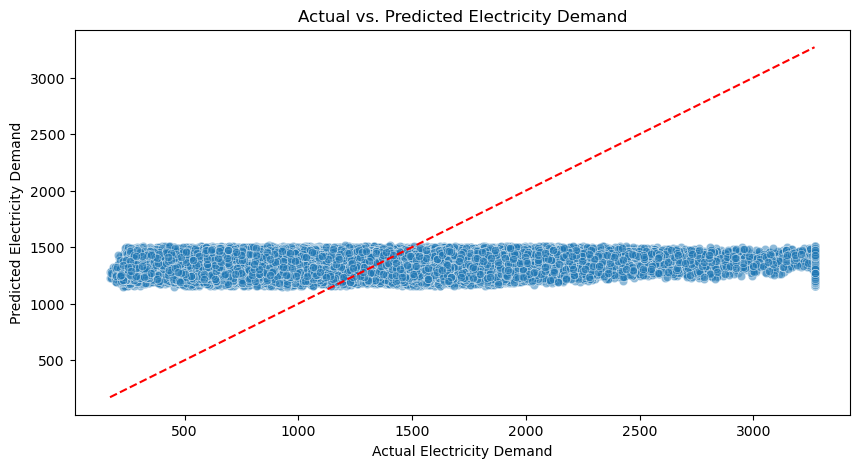

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='dashed')
plt.xlabel("Actual Electricity Demand")
plt.ylabel("Predicted Electricity Demand")
plt.title("Actual vs. Predicted Electricity Demand")
plt.show()
# actual vs predicted values 

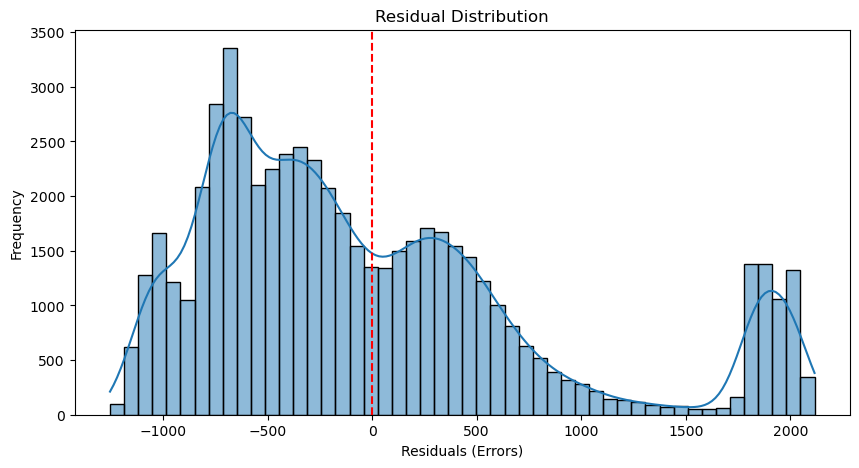

In [30]:
residuals = y_test - y_pred

plt.figure(figsize=(10, 5))
sns.histplot(residuals, bins=50, kde=True)
plt.axvline(x=0, color='red', linestyle='dashed')
plt.xlabel("Residuals (Errors)")
plt.ylabel("Frequency")
plt.title("Residual Distribution")
plt.show()
# check if residuals (errors) are randomly distributed, which is a key assumption for regression.